In [1]:
import torch
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from catalyst.dl import SupervisedRunner
from util.data import read_data, days_idx
from util.model import CovidDataset
from util.features import *

countries, data = read_data(
    countries_path='data/countries.csv',
    confirmed_path='data/time_series_covid19_confirmed_global.csv',
    deaths_path='data/time_series_covid19_deaths_global.csv',
)

data['confirmed'] = np.log10(data['confirmed'] + 1)
data['deaths'] = np.log10(data['deaths'] + 1)
data.head()

/home/tyz910/anaconda3/envs/sberbank-covid19/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.
alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.


,date,country,confirmed,deaths
0,2020-01-22,CN,2.739572,1.255273
1,2020-01-22,TW,0.301030,0.000000
2,2020-01-22,JP,0.477121,0.000000
3,2020-01-22,KR,0.301030,0.000000
4,2020-01-22,TH,0.477121,0.000000


# Отделяем данные для валидации

In [2]:
VALID_DAYS = 5
train_idx = days_idx(data, VALID_DAYS, after=False)
valid_idx = days_idx(data, VALID_DAYS, after=True)

len(train_idx), len(valid_idx)

(4767, 845)

# Генерация фичей

In [3]:
def get_y(df):
    return df[['confirmed', 'deaths']]

def get_X(df):
    X = df.copy()

    add_prev_values(X, "confirmed", days=5)
    add_prev_values(X, "deaths", days=5)

    return X.drop(columns=['date', 'country', 'confirmed', 'deaths'])

X, y = get_X(data), get_y(data)
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_valid, y_valid = X.loc[valid_idx], y.loc[valid_idx]

X_train.tail()

,confirmed_prev_1,confirmed_prev_2,confirmed_prev_3,confirmed_prev_4,confirmed_prev_5,deaths_prev_1,deaths_prev_2,deaths_prev_3,deaths_prev_4,deaths_prev_5
4762,2.318063,2.257679,2.184691,2.167317,2.060698,1.079181,1.00000,0.90309,0.69897,0.69897
4763,2.439333,2.378398,2.338456,2.278754,2.212188,0.000000,0.00000,0.00000,0.00000,0.00000
4764,2.021189,1.949390,1.880814,1.785330,1.707570,0.477121,0.30103,0.00000,0.00000,0.00000
4765,2.079181,2.033424,2.033424,1.963788,1.929419,0.477121,0.30103,0.00000,0.00000,0.00000
4766,1.462398,1.361728,1.230449,1.113943,0.602060,0.000000,0.00000,0.00000,0.00000,0.00000


# Обучение модели с валидацией

In [4]:
LOG_DIR = "./logs"
NUM_EPOCHS = 200
BATCH_SIZE = 2048
NUM_FEATURES = len(X_train.columns)
NUM_TARGETS = len(y_train.columns)


class CovidModel(torch.nn.Module):
    def __init__(self):
        super(CovidModel, self).__init__()
        self.linear = torch.nn.Linear(NUM_FEATURES, NUM_TARGETS)

    def forward(self, X):
        y = self.linear(X)        

        return y


model=CovidModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

runner = SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders={
        "train": DataLoader(CovidDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True),
        "valid": DataLoader(CovidDataset(X_valid, y_valid), batch_size=BATCH_SIZE, shuffle=False),
    },
    logdir=LOG_DIR,
    num_epochs=NUM_EPOCHS,
)

[2020-04-05 17:27:17,790] 
1/200 * Epoch 1 (_base): lr=0.1000 | momentum=0.9000
1/200 * Epoch 1 (train): _timer/_fps=250716.4097 | _timer/batch_time=0.0111 | _timer/data_time=0.0107 | _timer/model_time=0.0004 | loss=1.3314
1/200 * Epoch 1 (valid): _timer/_fps=387230.5185 | _timer/batch_time=0.0053 | _timer/data_time=0.0051 | _timer/model_time=0.0002 | loss=2.1358
[2020-04-05 17:27:17,874] 
2/200 * Epoch 2 (_base): lr=0.1000 | momentum=0.9000
2/200 * Epoch 2 (train): _timer/_fps=119580.9268 | _timer/batch_time=0.0245 | _timer/data_time=0.0242 | _timer/model_time=0.0002 | loss=1.0062
2/200 * Epoch 2 (valid): _timer/_fps=471094.3617 | _timer/batch_time=0.0043 | _timer/data_time=0.0042 | _timer/model_time=0.0001 | loss=1.8564
[2020-04-05 17:27:17,916] 
3/200 * Epoch 3 (_base): lr=0.1000 | momentum=0.9000
3/200 * Epoch 3 (train): _timer/_fps=257298.4970 | _timer/batch_time=0.0102 | _timer/data_time=0.0100 | _timer/model_time=0.0002 | loss=0.3889
3/200 * Epoch 3 (valid): _timer/_fps=462894.5

[2020-04-05 17:27:18,856] 
24/200 * Epoch 24 (_base): lr=0.1000 | momentum=0.9000
24/200 * Epoch 24 (train): _timer/_fps=221817.9757 | _timer/batch_time=0.0240 | _timer/data_time=0.0238 | _timer/model_time=0.0002 | loss=0.0270
24/200 * Epoch 24 (valid): _timer/_fps=464848.4546 | _timer/batch_time=0.0044 | _timer/data_time=0.0043 | _timer/model_time=0.0001 | loss=0.0181
[2020-04-05 17:27:18,896] 
25/200 * Epoch 25 (_base): lr=0.1000 | momentum=0.9000
25/200 * Epoch 25 (train): _timer/_fps=266030.1106 | _timer/batch_time=0.0098 | _timer/data_time=0.0096 | _timer/model_time=0.0002 | loss=0.0276
25/200 * Epoch 25 (valid): _timer/_fps=471327.0009 | _timer/batch_time=0.0043 | _timer/data_time=0.0042 | _timer/model_time=0.0001 | loss=0.0169
[2020-04-05 17:27:18,936] 
26/200 * Epoch 26 (_base): lr=0.1000 | momentum=0.9000
26/200 * Epoch 26 (train): _timer/_fps=268825.6955 | _timer/batch_time=0.0096 | _timer/data_time=0.0094 | _timer/model_time=0.0002 | loss=0.0260
26/200 * Epoch 26 (valid): _t

[2020-04-05 17:27:19,924] 
47/200 * Epoch 47 (_base): lr=0.1000 | momentum=0.9000
47/200 * Epoch 47 (train): _timer/_fps=264686.2889 | _timer/batch_time=0.0098 | _timer/data_time=0.0096 | _timer/model_time=0.0002 | loss=0.0150
47/200 * Epoch 47 (valid): _timer/_fps=268653.7372 | _timer/batch_time=0.0076 | _timer/data_time=0.0073 | _timer/model_time=0.0003 | loss=0.0075
[2020-04-05 17:27:19,968] 
48/200 * Epoch 48 (_base): lr=0.1000 | momentum=0.9000
48/200 * Epoch 48 (train): _timer/_fps=262572.9408 | _timer/batch_time=0.0103 | _timer/data_time=0.0101 | _timer/model_time=0.0002 | loss=0.0153
48/200 * Epoch 48 (valid): _timer/_fps=473483.3311 | _timer/batch_time=0.0043 | _timer/data_time=0.0042 | _timer/model_time=0.0001 | loss=0.0074
[2020-04-05 17:27:20,011] 
49/200 * Epoch 49 (_base): lr=0.1000 | momentum=0.9000
49/200 * Epoch 49 (train): _timer/_fps=250710.9020 | _timer/batch_time=0.0105 | _timer/data_time=0.0102 | _timer/model_time=0.0002 | loss=0.0149
49/200 * Epoch 49 (valid): _t

[2020-04-05 17:27:21,029] 
70/200 * Epoch 70 (_base): lr=0.1000 | momentum=0.9000
70/200 * Epoch 70 (train): _timer/_fps=259785.9138 | _timer/batch_time=0.0100 | _timer/data_time=0.0098 | _timer/model_time=0.0002 | loss=0.0115
70/200 * Epoch 70 (valid): _timer/_fps=465226.0936 | _timer/batch_time=0.0044 | _timer/data_time=0.0043 | _timer/model_time=0.0001 | loss=0.0052
[2020-04-05 17:27:21,074] 
71/200 * Epoch 71 (_base): lr=0.1000 | momentum=0.9000
71/200 * Epoch 71 (train): _timer/_fps=259404.6575 | _timer/batch_time=0.0104 | _timer/data_time=0.0102 | _timer/model_time=0.0002 | loss=0.0113
71/200 * Epoch 71 (valid): _timer/_fps=465024.6098 | _timer/batch_time=0.0044 | _timer/data_time=0.0043 | _timer/model_time=0.0001 | loss=0.0053
[2020-04-05 17:27:21,112] 
72/200 * Epoch 72 (_base): lr=0.1000 | momentum=0.9000
72/200 * Epoch 72 (train): _timer/_fps=273041.3330 | _timer/batch_time=0.0090 | _timer/data_time=0.0088 | _timer/model_time=0.0002 | loss=0.0128
72/200 * Epoch 72 (valid): _t

[2020-04-05 17:27:22,129] 
93/200 * Epoch 93 (_base): lr=0.1000 | momentum=0.9000
93/200 * Epoch 93 (train): _timer/_fps=271929.4345 | _timer/batch_time=0.0095 | _timer/data_time=0.0093 | _timer/model_time=0.0002 | loss=0.0107
93/200 * Epoch 93 (valid): _timer/_fps=461204.5419 | _timer/batch_time=0.0044 | _timer/data_time=0.0043 | _timer/model_time=0.0001 | loss=0.0043
[2020-04-05 17:27:22,171] 
94/200 * Epoch 94 (_base): lr=0.1000 | momentum=0.9000
94/200 * Epoch 94 (train): _timer/_fps=259392.8532 | _timer/batch_time=0.0103 | _timer/data_time=0.0101 | _timer/model_time=0.0002 | loss=0.0103
94/200 * Epoch 94 (valid): _timer/_fps=455699.4479 | _timer/batch_time=0.0045 | _timer/data_time=0.0044 | _timer/model_time=0.0001 | loss=0.0044
[2020-04-05 17:27:22,211] 
95/200 * Epoch 95 (_base): lr=0.1000 | momentum=0.9000
95/200 * Epoch 95 (train): _timer/_fps=258023.6281 | _timer/batch_time=0.0092 | _timer/data_time=0.0090 | _timer/model_time=0.0002 | loss=0.0118
95/200 * Epoch 95 (valid): _t

[2020-04-05 17:27:23,187] 
115/200 * Epoch 115 (_base): lr=0.1000 | momentum=0.9000
115/200 * Epoch 115 (train): _timer/_fps=257674.7929 | _timer/batch_time=0.0105 | _timer/data_time=0.0103 | _timer/model_time=0.0002 | loss=0.0099
115/200 * Epoch 115 (valid): _timer/_fps=473378.9591 | _timer/batch_time=0.0043 | _timer/data_time=0.0042 | _timer/model_time=0.0001 | loss=0.0039
[2020-04-05 17:27:23,233] 
116/200 * Epoch 116 (_base): lr=0.1000 | momentum=0.9000
116/200 * Epoch 116 (train): _timer/_fps=261990.1245 | _timer/batch_time=0.0101 | _timer/data_time=0.0099 | _timer/model_time=0.0002 | loss=0.0114
116/200 * Epoch 116 (valid): _timer/_fps=467301.4140 | _timer/batch_time=0.0044 | _timer/data_time=0.0042 | _timer/model_time=0.0001 | loss=0.0038
[2020-04-05 17:27:23,275] 
117/200 * Epoch 117 (_base): lr=0.1000 | momentum=0.9000
117/200 * Epoch 117 (train): _timer/_fps=280362.1515 | _timer/batch_time=0.0089 | _timer/data_time=0.0087 | _timer/model_time=0.0002 | loss=0.0097
117/200 * Epo

[2020-04-05 17:27:24,250] 
137/200 * Epoch 137 (_base): lr=0.1000 | momentum=0.9000
137/200 * Epoch 137 (train): _timer/_fps=239865.6543 | _timer/batch_time=0.0104 | _timer/data_time=0.0102 | _timer/model_time=0.0002 | loss=0.0114
137/200 * Epoch 137 (valid): _timer/_fps=397590.1223 | _timer/batch_time=0.0052 | _timer/data_time=0.0050 | _timer/model_time=0.0001 | loss=0.0037
[2020-04-05 17:27:24,295] 
138/200 * Epoch 138 (_base): lr=0.1000 | momentum=0.9000
138/200 * Epoch 138 (train): _timer/_fps=269233.7508 | _timer/batch_time=0.0092 | _timer/data_time=0.0090 | _timer/model_time=0.0002 | loss=0.0098
138/200 * Epoch 138 (valid): _timer/_fps=458472.1708 | _timer/batch_time=0.0045 | _timer/data_time=0.0043 | _timer/model_time=0.0002 | loss=0.0037
[2020-04-05 17:27:24,379] 
139/200 * Epoch 139 (_base): lr=0.1000 | momentum=0.9000
139/200 * Epoch 139 (train): _timer/_fps=222915.1650 | _timer/batch_time=0.0239 | _timer/data_time=0.0237 | _timer/model_time=0.0002 | loss=0.0095
139/200 * Epo

[2020-04-05 17:27:25,341] 
159/200 * Epoch 159 (_base): lr=0.1000 | momentum=0.9000
159/200 * Epoch 159 (train): _timer/_fps=237275.6824 | _timer/batch_time=0.0106 | _timer/data_time=0.0104 | _timer/model_time=0.0002 | loss=0.0097
159/200 * Epoch 159 (valid): _timer/_fps=389054.5130 | _timer/batch_time=0.0053 | _timer/data_time=0.0051 | _timer/model_time=0.0001 | loss=0.0035
[2020-04-05 17:27:25,437] 
160/200 * Epoch 160 (_base): lr=0.1000 | momentum=0.9000
160/200 * Epoch 160 (train): _timer/_fps=203108.5149 | _timer/batch_time=0.0274 | _timer/data_time=0.0272 | _timer/model_time=0.0002 | loss=0.0102
160/200 * Epoch 160 (valid): _timer/_fps=466261.4445 | _timer/batch_time=0.0044 | _timer/data_time=0.0043 | _timer/model_time=0.0001 | loss=0.0040
[2020-04-05 17:27:25,481] 
161/200 * Epoch 161 (_base): lr=0.1000 | momentum=0.9000
161/200 * Epoch 161 (train): _timer/_fps=252918.0024 | _timer/batch_time=0.0104 | _timer/data_time=0.0102 | _timer/model_time=0.0002 | loss=0.0099
161/200 * Epo

[2020-04-05 17:27:26,524] 
181/200 * Epoch 181 (_base): lr=0.1000 | momentum=0.9000
181/200 * Epoch 181 (train): _timer/_fps=242650.8209 | _timer/batch_time=0.0114 | _timer/data_time=0.0112 | _timer/model_time=0.0002 | loss=0.0099
181/200 * Epoch 181 (valid): _timer/_fps=462545.6137 | _timer/batch_time=0.0044 | _timer/data_time=0.0043 | _timer/model_time=0.0001 | loss=0.0046
[2020-04-05 17:27:26,575] 
182/200 * Epoch 182 (_base): lr=0.1000 | momentum=0.9000
182/200 * Epoch 182 (train): _timer/_fps=250527.8786 | _timer/batch_time=0.0108 | _timer/data_time=0.0105 | _timer/model_time=0.0002 | loss=0.0098
182/200 * Epoch 182 (valid): _timer/_fps=376124.6428 | _timer/batch_time=0.0054 | _timer/data_time=0.0053 | _timer/model_time=0.0002 | loss=0.0034
[2020-04-05 17:27:26,622] 
183/200 * Epoch 183 (_base): lr=0.1000 | momentum=0.9000
183/200 * Epoch 183 (train): _timer/_fps=232083.6709 | _timer/batch_time=0.0109 | _timer/data_time=0.0107 | _timer/model_time=0.0002 | loss=0.0098
183/200 * Epo

# Визуализация

In [5]:
def plot_preds(data_pred, country, column='confirmed', num_days=30):  
    data_country = data_pred[data_pred['country'] == country].copy()

    val_columns = ['confirmed', 'deaths', 'prediction_confirmed', 'prediction_deaths']
    data_country[val_columns] = 10 ** data_country[val_columns] - 1
    
    return data_country.reset_index().tail(num_days)[[column, 'prediction_' + column]].plot()


predictions = runner.predict_loader(
    model,
    DataLoader(CovidDataset(X_valid, y_valid), batch_size=BATCH_SIZE, shuffle=False),
)

data_pred = data.join(
    pd.DataFrame(predictions, columns=['prediction_confirmed', 'prediction_deaths'], index=valid_idx)
)
data_pred

,date,country,confirmed,deaths,prediction_confirmed,prediction_deaths
0,2020-01-22,CN,2.739572,1.255273,NaN,NaN
1,2020-01-22,TW,0.301030,0.000000,NaN,NaN
2,2020-01-22,JP,0.477121,0.000000,NaN,NaN
3,2020-01-22,KR,0.301030,0.000000,NaN,NaN
4,2020-01-22,TH,0.477121,0.000000,NaN,NaN
...,...,...,...,...,...,...
5607,2020-04-03,BF,2.481443,1.230449,2.517160,1.255186
5608,2020-04-03,UY,2.568202,0.698970,2.610538,0.738857
5609,2020-04-03,UZ,2.357935,0.477121,2.352897,0.501576
5610,2020-04-03,VE,2.187521,0.903090,2.239345,0.801648


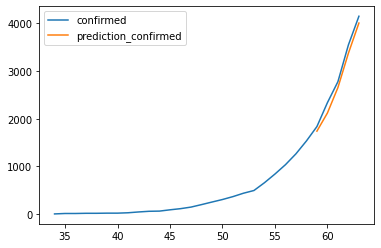

In [6]:
plot_preds(data_pred, 'RU', 'confirmed')

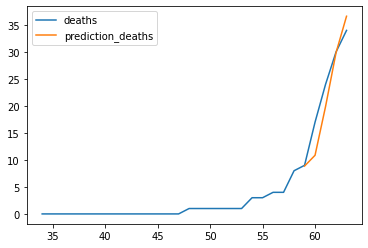

In [7]:
plot_preds(data_pred, 'RU', 'deaths')

# Обучение модели на всем датасете

In [8]:
model_final=CovidModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

runner = SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders={
        "train": DataLoader(CovidDataset(X, y), batch_size=BATCH_SIZE, shuffle=True),
    },
    logdir=LOG_DIR,
    num_epochs=NUM_EPOCHS,
)

Attention, there is only one data loader - train


[2020-04-05 17:27:27,974] 
1/200 * Epoch 1 (_base): lr=0.1000 | momentum=0.9000
1/200 * Epoch 1 (train): _timer/_fps=180635.8621 | _timer/batch_time=0.0117 | _timer/data_time=0.0115 | _timer/model_time=0.0002 | loss=0.6331
[2020-04-05 17:27:28,012] 
2/200 * Epoch 2 (_base): lr=0.1000 | momentum=0.9000
2/200 * Epoch 2 (train): _timer/_fps=187743.6923 | _timer/batch_time=0.0111 | _timer/data_time=0.0109 | _timer/model_time=0.0002 | loss=0.7155
[2020-04-05 17:27:28,051] 
3/200 * Epoch 3 (_base): lr=0.1000 | momentum=0.9000
3/200 * Epoch 3 (train): _timer/_fps=186607.8617 | _timer/batch_time=0.0113 | _timer/data_time=0.0110 | _timer/model_time=0.0002 | loss=0.1518
[2020-04-05 17:27:28,153] 
4/200 * Epoch 4 (_base): lr=0.1000 | momentum=0.9000
4/200 * Epoch 4 (train): _timer/_fps=127863.0931 | _timer/batch_time=0.0317 | _timer/data_time=0.0315 | _timer/model_time=0.0002 | loss=0.3847
[2020-04-05 17:27:28,190] 
5/200 * Epoch 5 (_base): lr=0.1000 | momentum=0.9000
5/200 * Epoch 5 (train): _ti

[2020-04-05 17:27:29,761] 
38/200 * Epoch 38 (_base): lr=0.1000 | momentum=0.9000
38/200 * Epoch 38 (train): _timer/_fps=197116.6950 | _timer/batch_time=0.0105 | _timer/data_time=0.0103 | _timer/model_time=0.0002 | loss=0.0089
[2020-04-05 17:27:29,812] 
39/200 * Epoch 39 (_base): lr=0.1000 | momentum=0.9000
39/200 * Epoch 39 (train): _timer/_fps=156619.3028 | _timer/batch_time=0.0143 | _timer/data_time=0.0141 | _timer/model_time=0.0002 | loss=0.0089
[2020-04-05 17:27:29,850] 
40/200 * Epoch 40 (_base): lr=0.1000 | momentum=0.9000
40/200 * Epoch 40 (train): _timer/_fps=188972.2213 | _timer/batch_time=0.0110 | _timer/data_time=0.0108 | _timer/model_time=0.0002 | loss=0.0089
[2020-04-05 17:27:29,888] 
41/200 * Epoch 41 (_base): lr=0.1000 | momentum=0.9000
41/200 * Epoch 41 (train): _timer/_fps=192959.7563 | _timer/batch_time=0.0109 | _timer/data_time=0.0107 | _timer/model_time=0.0002 | loss=0.0090
[2020-04-05 17:27:29,930] 
42/200 * Epoch 42 (_base): lr=0.1000 | momentum=0.9000
42/200 * E

[2020-04-05 17:27:31,578] 
75/200 * Epoch 75 (_base): lr=0.1000 | momentum=0.9000
75/200 * Epoch 75 (train): _timer/_fps=183948.8772 | _timer/batch_time=0.0114 | _timer/data_time=0.0112 | _timer/model_time=0.0002 | loss=0.0090
[2020-04-05 17:27:31,676] 
76/200 * Epoch 76 (_base): lr=0.1000 | momentum=0.9000
76/200 * Epoch 76 (train): _timer/_fps=146822.6687 | _timer/batch_time=0.0308 | _timer/data_time=0.0305 | _timer/model_time=0.0002 | loss=0.0092
[2020-04-05 17:27:31,717] 
77/200 * Epoch 77 (_base): lr=0.1000 | momentum=0.9000
77/200 * Epoch 77 (train): _timer/_fps=188883.2563 | _timer/batch_time=0.0112 | _timer/data_time=0.0110 | _timer/model_time=0.0002 | loss=0.0091
[2020-04-05 17:27:31,757] 
78/200 * Epoch 78 (_base): lr=0.1000 | momentum=0.9000
78/200 * Epoch 78 (train): _timer/_fps=188952.9232 | _timer/batch_time=0.0111 | _timer/data_time=0.0109 | _timer/model_time=0.0002 | loss=0.0088
[2020-04-05 17:27:31,798] 
79/200 * Epoch 79 (_base): lr=0.1000 | momentum=0.9000
79/200 * E

[2020-04-05 17:27:33,389] 
111/200 * Epoch 111 (_base): lr=0.1000 | momentum=0.9000
111/200 * Epoch 111 (train): _timer/_fps=161196.4204 | _timer/batch_time=0.0129 | _timer/data_time=0.0126 | _timer/model_time=0.0003 | loss=0.0090
[2020-04-05 17:27:33,438] 
112/200 * Epoch 112 (_base): lr=0.1000 | momentum=0.9000
112/200 * Epoch 112 (train): _timer/_fps=168411.6269 | _timer/batch_time=0.0128 | _timer/data_time=0.0126 | _timer/model_time=0.0002 | loss=0.0089
[2020-04-05 17:27:33,479] 
113/200 * Epoch 113 (_base): lr=0.1000 | momentum=0.9000
113/200 * Epoch 113 (train): _timer/_fps=184778.7473 | _timer/batch_time=0.0116 | _timer/data_time=0.0114 | _timer/model_time=0.0002 | loss=0.0093
[2020-04-05 17:27:33,520] 
114/200 * Epoch 114 (_base): lr=0.1000 | momentum=0.9000
114/200 * Epoch 114 (train): _timer/_fps=186439.9032 | _timer/batch_time=0.0114 | _timer/data_time=0.0112 | _timer/model_time=0.0002 | loss=0.0088
[2020-04-05 17:27:33,563] 
115/200 * Epoch 115 (_base): lr=0.1000 | momentum

[2020-04-05 17:27:35,087] 
147/200 * Epoch 147 (_base): lr=0.1000 | momentum=0.9000
147/200 * Epoch 147 (train): _timer/_fps=186432.3901 | _timer/batch_time=0.0113 | _timer/data_time=0.0111 | _timer/model_time=0.0002 | loss=0.0089
[2020-04-05 17:27:35,130] 
148/200 * Epoch 148 (_base): lr=0.1000 | momentum=0.9000
148/200 * Epoch 148 (train): _timer/_fps=179230.2287 | _timer/batch_time=0.0117 | _timer/data_time=0.0115 | _timer/model_time=0.0002 | loss=0.0092
[2020-04-05 17:27:35,170] 
149/200 * Epoch 149 (_base): lr=0.1000 | momentum=0.9000
149/200 * Epoch 149 (train): _timer/_fps=191139.3550 | _timer/batch_time=0.0108 | _timer/data_time=0.0106 | _timer/model_time=0.0002 | loss=0.0089
[2020-04-05 17:27:35,212] 
150/200 * Epoch 150 (_base): lr=0.1000 | momentum=0.9000
150/200 * Epoch 150 (train): _timer/_fps=179007.5528 | _timer/batch_time=0.0115 | _timer/data_time=0.0113 | _timer/model_time=0.0002 | loss=0.0089
[2020-04-05 17:27:35,313] 
151/200 * Epoch 151 (_base): lr=0.1000 | momentum

[2020-04-05 17:27:36,897] 
183/200 * Epoch 183 (_base): lr=0.1000 | momentum=0.9000
183/200 * Epoch 183 (train): _timer/_fps=141113.7632 | _timer/batch_time=0.0314 | _timer/data_time=0.0312 | _timer/model_time=0.0002 | loss=0.0088
[2020-04-05 17:27:36,944] 
184/200 * Epoch 184 (_base): lr=0.1000 | momentum=0.9000
184/200 * Epoch 184 (train): _timer/_fps=185970.5192 | _timer/batch_time=0.0115 | _timer/data_time=0.0113 | _timer/model_time=0.0002 | loss=0.0088
[2020-04-05 17:27:36,992] 
185/200 * Epoch 185 (_base): lr=0.1000 | momentum=0.9000
185/200 * Epoch 185 (train): _timer/_fps=159356.3780 | _timer/batch_time=0.0131 | _timer/data_time=0.0129 | _timer/model_time=0.0002 | loss=0.0089
[2020-04-05 17:27:37,034] 
186/200 * Epoch 186 (_base): lr=0.1000 | momentum=0.9000
186/200 * Epoch 186 (train): _timer/_fps=188040.5244 | _timer/batch_time=0.0112 | _timer/data_time=0.0110 | _timer/model_time=0.0002 | loss=0.0088
[2020-04-05 17:27:37,073] 
187/200 * Epoch 187 (_base): lr=0.1000 | momentum

# Предсказание

In [9]:
PREDICT_DAYS = 14

def predict_next_day(current_data):
    last_date = current_data['date'].max()
    next_date = last_date + pd.to_timedelta(1, unit='d')

    prev_data = current_data[current_data['date'] == last_date]
    values = []
    for country in prev_data['country']:
        values.append([next_date, country, 0, 0])

    next_data = pd.DataFrame(values, columns=current_data.columns)
    combined_data = current_data.append(next_data)
    next_X = get_X(combined_data)[combined_data['date'] == next_date]

    next_data[['confirmed', 'deaths']] = runner.predict_loader(
        model,
        DataLoader(CovidDataset(next_X), batch_size=BATCH_SIZE, shuffle=False),
    )

    return next_data

def predict(data, num_days=PREDICT_DAYS):
    predict_data = pd.DataFrame(columns=data.columns)
    for i in range(PREDICT_DAYS):
        predict_data = predict_data.append(predict_next_day(data.append(predict_data)))

    return predict_data.rename(columns={
        'confirmed': 'prediction_confirmed',
        'deaths': 'prediction_deaths',
    })

predicts = predict(data)
predicts

,date,country,prediction_confirmed,prediction_deaths
0,2020-04-04,AF,2.513889,0.890111
1,2020-04-04,AL,2.543757,1.290457
2,2020-04-04,DZ,3.150461,2.087187
3,2020-04-04,AD,2.699232,1.280225
4,2020-04-04,AO,1.030868,0.477223
...,...,...,...,...
164,2020-04-17,BF,3.246746,1.715755
165,2020-04-17,UY,3.273564,1.477487
166,2020-04-17,UZ,3.010434,1.110891
167,2020-04-17,VE,3.056301,1.505088


# Визуализация

In [10]:
data_pred = data.append(predicts)

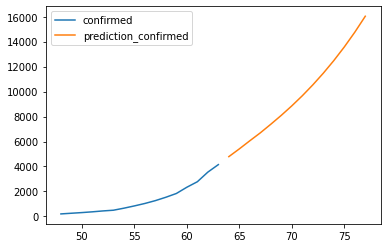

In [11]:
plot_preds(data_pred, 'RU', 'confirmed')

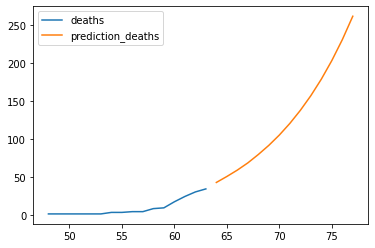

In [12]:
plot_preds(data_pred, 'RU', 'deaths')

# Сохранение

In [13]:
PREDICT_COLUMNS = ['prediction_confirmed', 'prediction_deaths']

df = predicts.copy()
df[PREDICT_COLUMNS] = (10 ** df[PREDICT_COLUMNS] - 1).astype(int)

df.to_csv('data/submission.csv', index=False)